In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

In [6]:
from typing import Callable, Optional

import logging

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Custom code
from coordination.common.sparse_series import SparseSeries
from coordination.component.speech.vocalics_component import VocalicsComponent
from coordination.entity.trial import Trial
from coordination.inference.vocalics import DiscreteCoordinationInferenceFromVocalics, ContinuousCoordinationInferenceFromVocalics
from coordination.plot.coordination import add_discrete_coordination_bar
from coordination.plot.vocalics import plot_vocalic_features

In [7]:
# Constants
NUM_TIME_STEPS = 17 * 60 #(17 minutes of mission in seconds)
M = int(NUM_TIME_STEPS/2) # We assume coordination in the second half of the period is constant
NUM_FEATURES = 2 # Pitch and Intensity

# Common parameters
MEAN_PRIOR_A = np.zeros(NUM_FEATURES)
MEAN_PRIOR_B = np.zeros(NUM_FEATURES)
STD_PRIOR_A = np.ones(NUM_FEATURES)
STD_PRIOR_B = np.ones(NUM_FEATURES)
ANTIPHASE_FUNCTION = lambda x, s: -x if s == 0 else x
ANYPHASE_FUNCTION = lambda x, s: np.abs(x)

# Parameters of the discrete model
P_COORDINATION_TRANSITION = 0.1 # Coordination changes with small probability
P_COORDINATION = 0 # The process starts with no coordination
STD_UNCOORDINATED_A = np.ones(NUM_FEATURES)
STD_UNCOORDINATED_B = np.ones(NUM_FEATURES)
STD_COORDINATED_A = np.ones(NUM_FEATURES)
STD_COORDINATED_B = np.ones(NUM_FEATURES)

# Parameters of the continuous model
MEAN_COORDINATION_PRIOR = 0; STD_COORDINATION_PRIOR = 0 # The process starts with no coordination
STD_COORDINATION_DRIFT = 0.1 # Coordination drifts by a little
STD_COUPLING_A = np.ones(NUM_FEATURES)
STD_COUPLING_B = np.ones(NUM_FEATURES)

In [38]:
def get_discrete_inference_engine(series_a: SparseSeries, series_b: SparseSeries, f: Optional[Callable] = lambda x, s : x):
    return DiscreteCoordinationInferenceFromVocalics(series_a=series_a, 
                                                     series_b=series_b, 
                                                     p_prior_coordination=P_COORDINATION, 
                                                     p_coordination_transition=P_COORDINATION_TRANSITION, 
                                                     mean_prior_a=MEAN_PRIOR_A,
                                                     mean_prior_b=MEAN_PRIOR_B,
                                                     std_prior_a=STD_PRIOR_A,
                                                     std_prior_b=STD_PRIOR_B,
                                                     std_uncoordinated_a=STD_UNCOORDINATED_A,
                                                     std_uncoordinated_b=STD_UNCOORDINATED_B,
                                                     std_coordinated_a=STD_COORDINATED_A,
                                                     std_coordinated_b=STD_COORDINATED_B,
                                                     f=f)

def get_continuous_inference_engine(series_a: SparseSeries, series_b: SparseSeries, f: Optional[Callable] = lambda x, s : x):
    return ContinuousCoordinationInferenceFromVocalics(series_a=series_a, 
                                                       series_b=series_b, 
                                                       mean_prior_coordination=MEAN_COORDINATION_PRIOR, 
                                                       std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                       std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                       mean_prior_a=MEAN_PRIOR_A,
                                                       mean_prior_b=MEAN_PRIOR_B,
                                                       std_prior_a=STD_PRIOR_A,
                                                       std_prior_b=STD_PRIOR_B,
                                                       std_coupling_a=STD_COUPLING_A,
                                                       std_coupling_b=STD_COUPLING_B,
                                                       f=f)

100%|██████████| 5/5 [01:02<00:00, 12.45s/it]


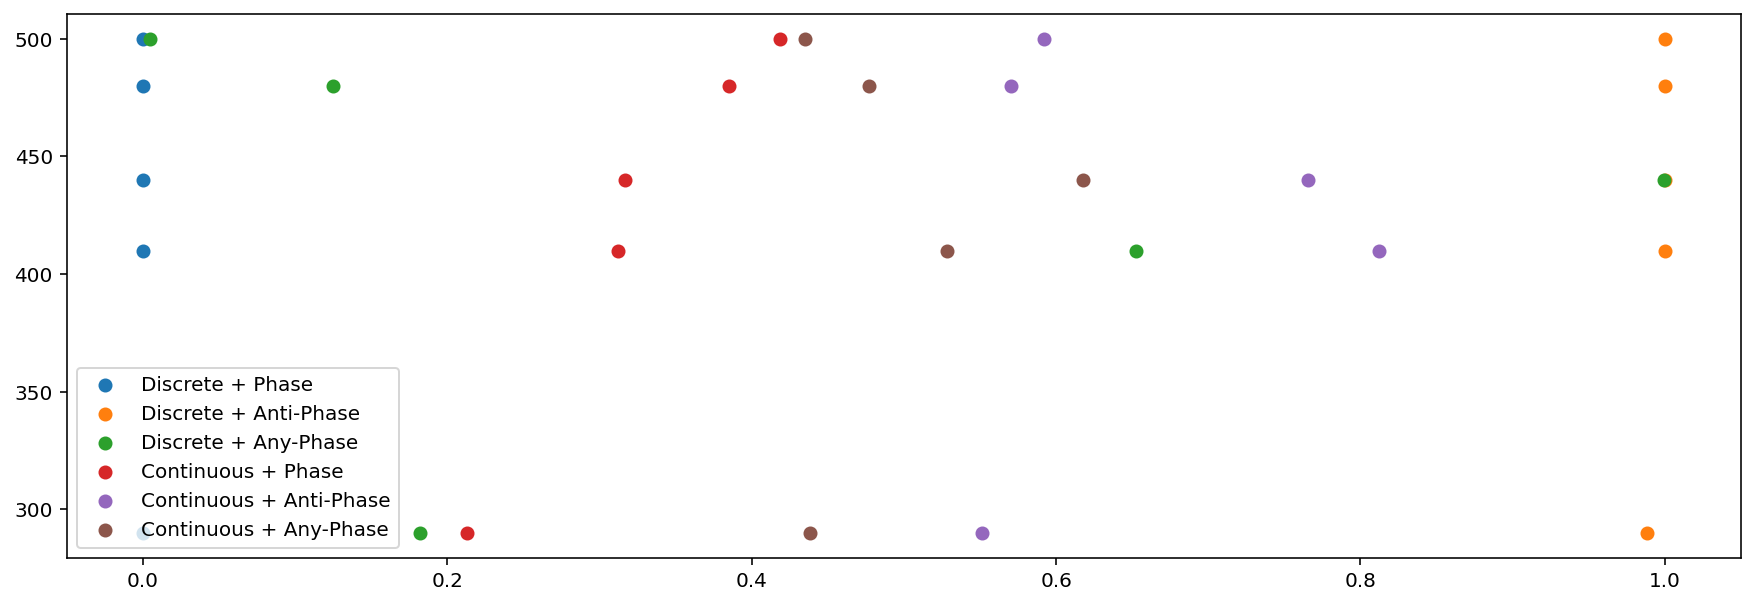

In [41]:
trials = ["T000745","T000821","T000822","T000841","T000853"]  # "T000842" "T000854"
scores = []
discrete_phase_probs = []
discrete_anti_phase_probs = []
discrete_any_phase_probs = []
continuous_phase_means = []
continuous_anti_phase_means = []
continuous_any_phase_means = []

logging.disable(logging.CRITICAL)

for trial_number in tqdm(trials):
    trial = Trial.from_directory(f"../data/study-3_2022/{trial_number}/") 
    vocalics_component = VocalicsComponent.from_trial_directory(f"../data/study-3_2022/{trial_number}/") 
    vocalics_a, vocalics_b = vocalics_component.sparse_series(NUM_TIME_STEPS)
    vocalics_a.normalize()
    vocalics_b.normalize()
    
    discrete_phase_inference_engine = get_discrete_inference_engine(vocalics_a, vocalics_b)
    discrete_antiphase_inference_engine = get_discrete_inference_engine(vocalics_a, vocalics_b, ANTIPHASE_FUNCTION)
    discrete_anyphase_inference_engine = get_discrete_inference_engine(vocalics_a, vocalics_b, ANYPHASE_FUNCTION)
    continuous_phase_inference_engine = get_continuous_inference_engine(vocalics_a, vocalics_b)
    continuous_antiphase_inference_engine = get_continuous_inference_engine(vocalics_a, vocalics_b, ANTIPHASE_FUNCTION)
    continuous_anyphase_inference_engine = get_continuous_inference_engine(vocalics_a, vocalics_b, ANYPHASE_FUNCTION)
    
    scores.append(trial.metadata.team_score)
    discrete_phase_probs.append(discrete_phase_inference_engine.estimate_marginals()[1, -1])
    discrete_anti_phase_probs.append(discrete_antiphase_inference_engine.estimate_marginals()[1, -1])
    discrete_any_phase_probs.append(discrete_anyphase_inference_engine.estimate_marginals()[1, -1])
    continuous_phase_means.append(continuous_phase_inference_engine.estimate_means_and_variances()[0, -1])
    continuous_anti_phase_means.append(continuous_antiphase_inference_engine.estimate_means_and_variances()[0, -1])
    continuous_any_phase_means.append(continuous_anyphase_inference_engine.estimate_means_and_variances()[0, -1])
    
fig = plt.figure(figsize=(15,5))
plt.scatter(discrete_phase_probs, scores, label="Discrete + Phase")
plt.scatter(discrete_anti_phase_probs, scores, label="Discrete + Anti-Phase")
plt.scatter(discrete_any_phase_probs, scores, label="Discrete + Any-Phase")
plt.scatter(continuous_phase_means, scores, label="Continuous + Phase")
plt.scatter(continuous_anti_phase_means, scores, label="Continuous + Anti-Phase")
plt.scatter(continuous_any_phase_means, scores, label="Continuous + Any-Phase")
plt.legend()

Text(0, 0.5, 'Final Team Score')

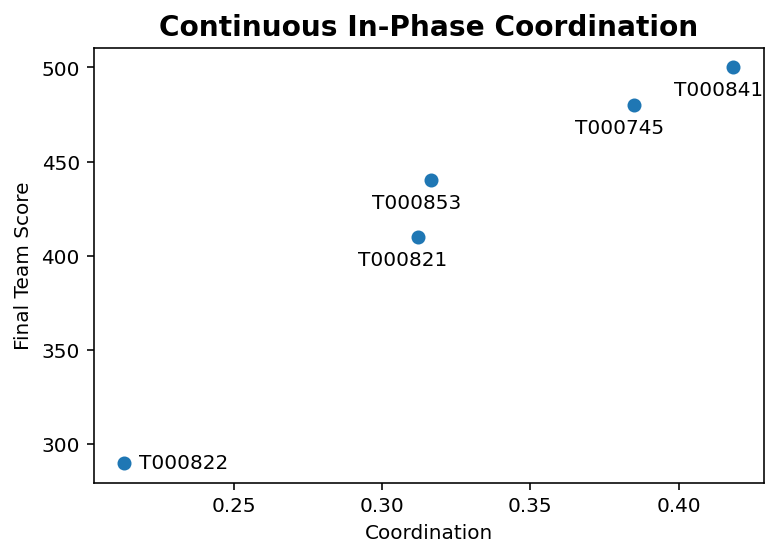

In [45]:
fig = plt.figure(figsize=(6,4))

plt.scatter(continuous_phase_means, scores)
for i, trial_number in enumerate(trials):
    if trial_number == "T000822":
        plt.annotate(trial_number, (continuous_phase_means[i] + 0.005, scores[i] - 3))
    else:
        plt.annotate(trial_number, (continuous_phase_means[i] - 0.02, scores[i] - 15))
plt.title("Continuous In-Phase Coordination", fontsize=14, weight="bold")
plt.xlabel("Coordination")
plt.ylabel("Final Team Score")